# Fine-tuning example for MT5 on a custom prompt dataset using `pytorch`

In [ ]:
# !pip install transformers datasets sentencepiece pandas matplotlib rouge_score nltk

In [ ]:
!sudo apt-get install git-lfs


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

## Configuration

In [1]:
model_id="GermanT5/t5-efficient-gc4-german-small-el32"
dataset_id = "philschmid/germeval18"

## Preprocess dataset

In [2]:
from datasets import load_dataset

ds = load_dataset(dataset_id)

Using custom data configuration philschmid___germeval18-d95f426c648a9760


  0%|          | 0/2 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/531k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/317k [00:00<?, ?B/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Dataset parquet downloaded and prepared to /home/ubuntu/.cache/huggingface/datasets/parquet/philschmid___germeval18-d95f426c648a9760/0.0.0/1638526fd0e8d960534e2155dc54fdff8dce73851f21f031d2fb9c2cf757c121. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

## inspect dataset to get an understanding of `max_input_length` and `max_target_length`

In [3]:
import pandas as pd

In [4]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("t5-small")

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

In [5]:
df = ds["train"].to_pandas()
df.sample()

,text,binary,multi
1464,@feldenfrizz @AthinaMala @info2099 @Nessie43 @...,OTHER,OTHER


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


<AxesSubplot:>

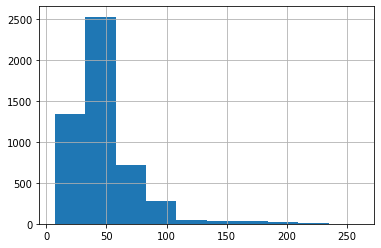

In [8]:
df["text"].map(lambda x: len(tokenizer.convert_ids_to_tokens(tokenizer(x).input_ids))).\
    hist()

In [ ]:
len(len_targets[len_targets > 128])

## tokenize dataset

In [9]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_id)

Downloading:   0%|          | 0.00/1.87k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/803k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.34M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.74k [00:00<?, ?B/s]

In [14]:
max_input_length = 256
max_target_length = 8


def preprocess_function(examples):
    model_inputs = tokenizer(
        examples["text"], max_length=max_input_length, truncation=True
    )
    # Set up the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            examples["multi"], max_length=max_target_length, truncation=True
        )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [15]:
tokenized_datasets = ds.map(preprocess_function, batched=True)


  0%|          | 0/6 [00:00<?, ?ba/s]

Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction


  0%|          | 0/4 [00:00<?, ?ba/s]

Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction


In [16]:
tokenized_datasets["test"][0]

{'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 'binary': 'OTHER',
 'input_ids': [6874,
  913,
  64,
  730,
  2803,
  4,
  51,
  3082,
  983,
  67,
  13038,
  18679,
  34,
  1414,
  64,
  4,
  354,
  5,
  114,
  7,
  14478,
  11,
  20323,
  21,
  10,
  2,
  1],
 'labels': [300, 10910, 3073, 1],
 'multi': 'OTHER',
 'text': 'Meine Mutter hat mir erzählt, dass mein Vater einen Wahlkreiskandidaten nicht gewählt hat, weil der gegen die Homo-Ehe ist ☺'}

In [17]:
# test size will be 15% of train dataset
test_size=.15
seed=33

processed_dataset = tokenized_datasets["train"].shuffle(seed=seed).train_test_split(test_size=test_size)
processed_dataset

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'binary', 'input_ids', 'labels', 'multi', 'text'],
        num_rows: 4257
    })
    test: Dataset({
        features: ['attention_mask', 'binary', 'input_ids', 'labels', 'multi', 'text'],
        num_rows: 752
    })
})

# Train the model

In [18]:
from transformers import AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained(model_id)
tokenizer = AutoTokenizer.from_pretrained(model_id)

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/543M [00:00<?, ?B/s]

In [19]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [27]:
from transformers import Seq2SeqTrainingArguments
from huggingface_hub import HfFolder

per_device_train_batch_size = 8
per_device_eval_batch_size = 16
num_train_epochs = 8
learning_rate = 5.6e-5
# Show the training loss with every epoch
logging_steps = len(processed_dataset["train"]) // per_device_train_batch_size
model_name = model_id.split("/")[-1]
output_dir=f"{model_name}-germeval18"
hub_token = HfFolder.get_token() # or your token directly "hf_xxx"
hub_model_id = f'{model_id.split("/")[1]}-{dataset_id.split("/")[1]}'

args = Seq2SeqTrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=per_device_train_batch_size,
    per_device_eval_batch_size=per_device_eval_batch_size,
    num_train_epochs=num_train_epochs,
    learning_rate=learning_rate,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=3,
    predict_with_generate=True,
    logging_steps=logging_steps,
    load_best_model_at_end=True,
    metric_for_best_model="rougeLsum",
    push_to_hub=True,
    hub_model_id=hub_model_id,
    hub_token=hub_token,   
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [28]:
import nltk

nltk.download("punkt")

[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [29]:
import numpy as np
from nltk.tokenize import sent_tokenize


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    # Decode generated summaries into text
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    # Decode reference summaries into text
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    # ROUGE expects a newline after each sentence
    decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]
    # Compute ROUGE scores
    result = metric.compute(
        predictions=decoded_preds, references=decoded_labels, use_stemmer=True
    )
    # Extract the median scores
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
    return {k: round(v, 4) for k, v in result.items()}

In [30]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Cloning https://huggingface.co/philschmid/t5-efficient-gc4-german-small-el32-germeval18 into local empty directory.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [31]:
trainer.train()


The following columns in the training set  don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: binary, text, multi.
/home/ubuntu/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 5009
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 5016


AttributeError: module 'tensorflow' has no attribute 'io'

In [ ]:
trainer.evaluate()


In [ ]:
trainer.push_to_hub(commit_message="Training complete", tags="text2text")
